# 03 - Selection Bias
In this notebook municpalities for which a sustainability vision is available are compared to ones for which no sustainability vision is avialable. This analysis is intended to assess if there is a selection bias between the municipalities.

---
## Imports and Data Loading

In [1]:
import re
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
CACHE_DIR = '../cache/Governance'

GLOB_DV = CACHE_DIR + '/GM????DV??.txt'

# take a glob and make it iterable. We cannot use globs as objects, since these get
# "exhausted" when you iterate over them.
# https://stackoverflow.com/questions/51108256/how-to-take-a-pathname-string-with-wildcards-and-resolve-the-glob-with-pathlib
def expand_glob(glob):
    p = Path(glob)
    return Path(p.parent).expanduser().glob(p.name)

print(f"'Duurzaamheidsvisie' documents = {GLOB_DV}")

DOCUMENT_BODY = 'body'

# create a list of unique municipality codes based on the filenames in the data
files = pd.DataFrame([file.stem for file in expand_glob(GLOB_DV)], columns=["FileName"])
files['Gemeente'] = files['FileName'].str.slice(0, 6)
gemeenten = pd.DataFrame(files['Gemeente'].unique(), columns=["Gemeente"])
gemeenten

'Duurzaamheidsvisie' documents = ../cache/Governance/GM????DV??.txt


,Gemeente
0,GM0003
1,GM0005
2,GM0007
3,GM0009
4,GM0034
...,...
203,GM1927
204,GM1940
205,GM1945
206,GM1955


In [3]:
# open files containing background data of municipalities
kern = pd.read_csv("../data/CBS/Regionale_kerncijfers.csv", sep=";", decimal=",")
energie = pd.read_csv("../data/CBS/Energieverbruik.csv", na_values=".")
hernieuw = pd.read_csv("../data/CBS/Hernieuwbare_energie.csv")
hernieuw_cbs = hernieuw.groupby('Gemeente_CBS')[['Totaal', 'Percentage', 'Wind', 'Zon']].sum().reset_index()

# merge the different files
gemac = kern.merge(energie, how="left", on='Gemeente')
gemac = gemac.merge(hernieuw_cbs, how='left', left_on='Gemeente', right_on='Gemeente_CBS').drop('Gemeente_CBS', axis=1)

# add an indication on the availability of a sustainability vision.
gemdvac = gemac.merge(gemeenten, how='left', left_on='GM_Code', right_on='Gemeente', indicator=True)
gemdvac['DV'] = ["Ja" if x == "both" else "Nee" for x in gemdvac['_merge']]
gemdvac

,Gemeente_x,Inwoners,Inkomen,OAD,PV_code,PV,GM_Code,Aardgas,Elektriciteit,Totaal,Percentage,Wind,Zon,Gemeente_y,_merge,DV
0,Appingedam,12001,34.2,1041,PV20,Groningen,GM0003,3194.0,86926.0,24,0.0,0.0,0,GM0003,both,Ja
1,Bedum,10433,40.2,681,PV20,Groningen,GM0005,23962.0,87317.0,30,0.0,6.0,0,GM0005,both,Ja
2,Bellingwedde,8971,36.9,151,PV20,Groningen,GM0007,2969.0,13678.0,54,7.4,0.0,1,GM0007,both,Ja
3,Ten Boer,7352,41.1,367,PV20,Groningen,GM0009,4844.0,13238.0,54,0.0,1.0,1,GM0009,both,Ja
4,Delfzijl,25068,35.1,681,PV20,Groningen,GM0010,512806.0,1285394.0,2088,0.0,673.0,1,NaN,left_only,Nee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,De Fryske Marren,51265,40.6,541,PV21,Fryslân,GM1940,42911.0,203943.0,387,6.2,49.0,5,GM1940,both,Ja
386,Gooise Meren,56696,54.9,1973,PV27,Noord-Holland,GM1942,18070.0,132451.0,25,1.3,0.0,0,NaN,left_only,Nee
387,Berg en Dal,34574,40.8,637,PV25,Gelderland,GM1945,14560.0,58006.0,102,0.0,0.0,1,GM1945,both,Ja
388,Montferland,35173,40.3,743,PV25,Gelderland,GM1955,21052.0,102951.0,119,4.2,0.0,4,GM1955,both,Ja


[Text(0.5, 0, 'Duurzaamheidsvisie beschikbaar'),
 Text(0, 0.5, 'Aantal inwoners (log schaal)'),
 None]

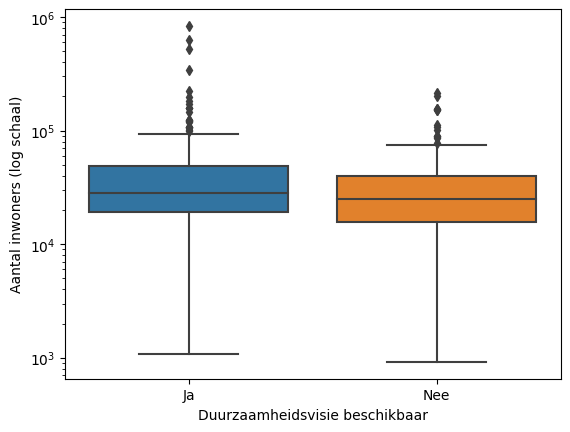

In [4]:
# explorative comparisons background data on municipalities by using graphics 
fig = sns.boxplot(x='DV', y='Inwoners', data=gemdvac) 
fig.set(xlabel="Duurzaamheidsvisie beschikbaar", ylabel="Aantal inwoners (log schaal)", yscale="log")
# De vier grote gemeenten hebben een document voor een duurzaamheidsvisie, voor de overige gemeenten lijken kleinere gemeenten licht ondervertegenwoordigd

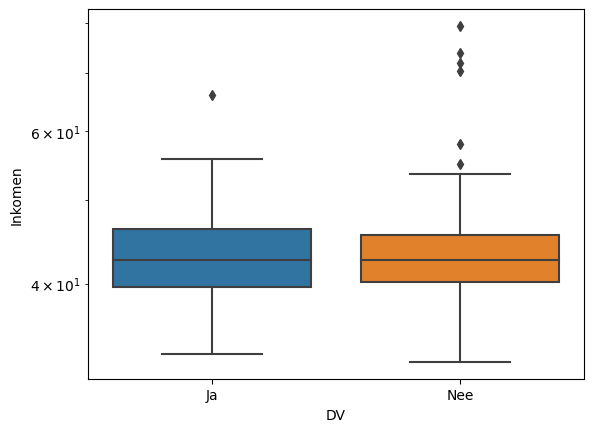

In [5]:
sns.boxplot(x='DV', y='Inkomen', data=gemdvac)
plt.yscale("log")

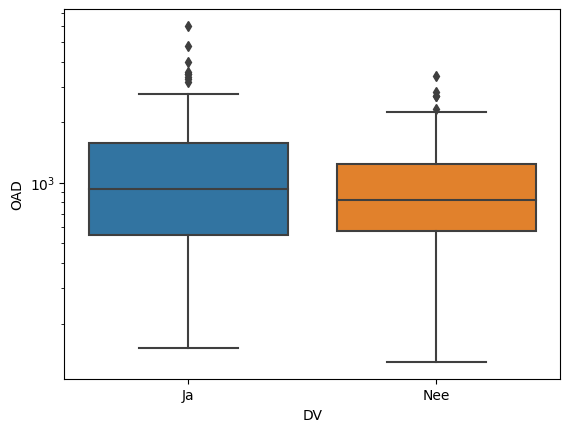

In [6]:
sns.boxplot(x='DV', y='OAD', data=gemdvac)
plt.yscale("log")

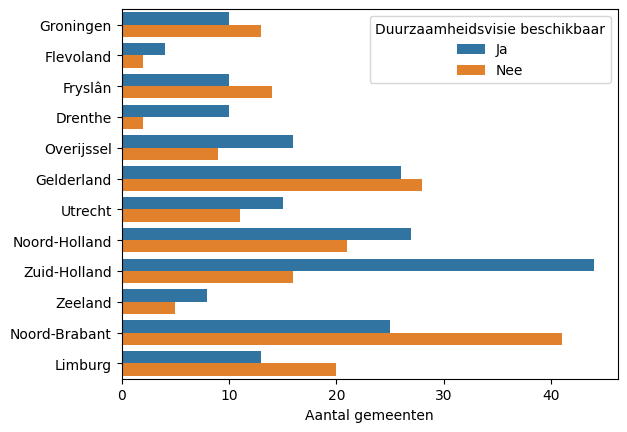

In [7]:
fig = sns.countplot(y='PV', hue='DV', data=gemdvac) 
fig.set(xlabel="Aantal gemeenten", ylabel=None)
fig.legend(title="Duurzaamheidsvisie beschikbaar")
# In Noord-Brabant zijn relatief weinig gemeenten met een document voor een duurzaamheidsvise, in Zuid-Holland, Overijssel en Drenthe zijn het er relatief veel.

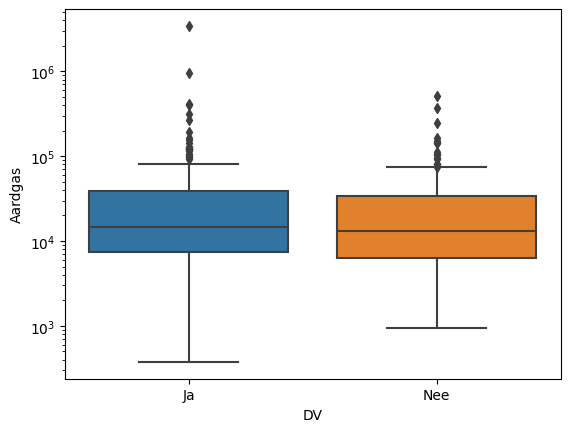

In [8]:
sns.boxplot(x='DV', y='Aardgas', data=gemdvac)
plt.yscale("log")

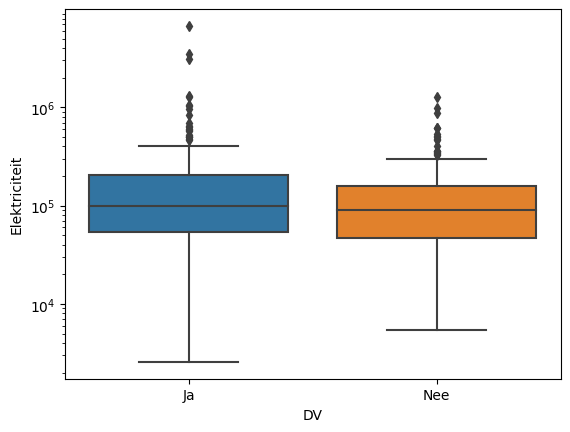

In [9]:
sns.boxplot(x='DV', y='Elektriciteit', data=gemdvac)
plt.yscale("log")

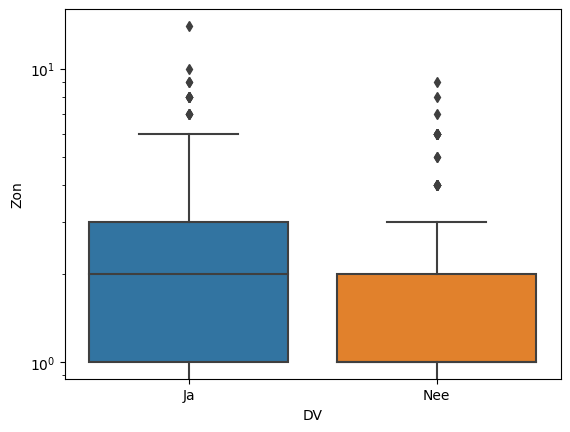

In [10]:
sns.boxplot(x='DV', y='Zon', data=gemdvac)
plt.yscale("log")

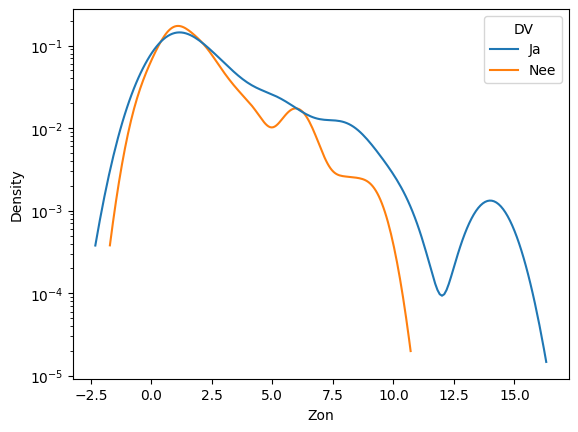

In [11]:
sns.kdeplot(x='Zon', hue='DV', data=gemdvac)
plt.yscale("log")

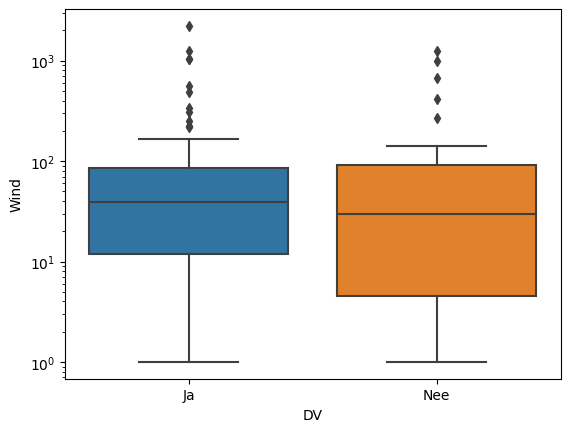

In [12]:
sns.boxplot(x='DV', y='Wind', data=gemdvac[gemdvac['Wind'] > 0])
plt.yscale("log")

<Axes: xlabel='Wind_dig', ylabel='count'>

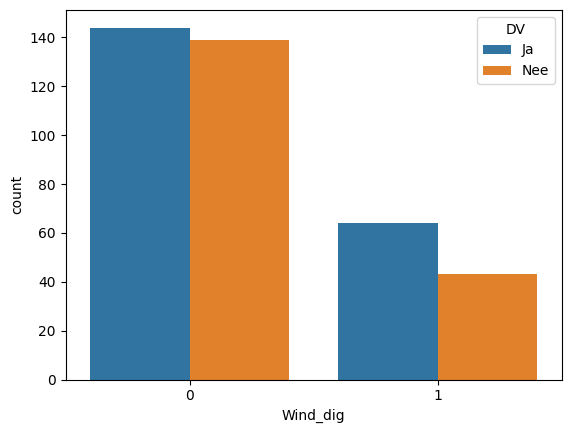

In [13]:
gemdvac['Wind_dig'] = [1 if x > 0 else 0 for x in gemdvac['Wind']]
sns.countplot(x='Wind_dig', hue='DV', data=gemdvac)